Copyright 2025 Quantinuum (www.quantinuum.com)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Example for the information theory QPE

This example only use the simplest non-FT setup. See `calibration.ipynb` to know more about different QEC setup.

In [1]:
import numpy as np
from pytket.circuit.display import render_circuit_jupyter

In [2]:
# Prepare the samples of (k, beta).
k_max = 5
n_samples = 25
k_list = np.random.randint(1, k_max+1, size=n_samples).tolist()
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()

In [3]:
# Prepare the iterative QPE circuits.
from h2xh2.experiment import build_iqpe_circuits

logical_circuits = build_iqpe_circuits(
    k_list=k_list,
    beta_list=beta_list,
    pft_rz=False,
    qec_level=0,
)
render_circuit_jupyter(logical_circuits[1])

In [4]:
# Encode the logical circuit.
from h2xh2.encode import encode, EncodeOptions, RzMode

encoded_circuits = [
    encode(
        circ,
        options=EncodeOptions(
            rz_mode=RzMode.DIRECT,
        )
    ) for circ in logical_circuits
]
render_circuit_jupyter(encoded_circuits[1])

In [5]:
# Compile the encoded circuits.
from pytket.extensions.quantinuum import (
    QuantinuumBackend,
    QuantinuumAPIOffline,
)

backend = QuantinuumBackend(
    device_name="H2-1LE",
    api_handler=QuantinuumAPIOffline(),
)
compiled_circuits = backend.get_compiled_circuits(
    encoded_circuits,
    optimisation_level=0,
)

In [6]:
# Execute the compiled (encoded) circuits.
N_SHOTS = 5

encoded_results = backend.run_circuits(
    compiled_circuits,
    n_shots=N_SHOTS,
)

In [7]:
# Interpret the encoded results back in the logical space.
from h2xh2.encode import interpret, InterpretOptions, ReadoutMode
logical_results = [
    interpret(
        result,
        options=InterpretOptions(
            readout_mode=ReadoutMode.Raw,
        ),
    ) for result in encoded_results
]

In [8]:
from h2xh2.experiment import ChemData
from h2xh2.algorithm import bootstrap_sampling, get_ms, bayesian_update

# Load the pre-computed chemistry data.
chem_data = ChemData()

ks, betas, ms = get_ms(k_list, beta_list, logical_results)

# Prepare the uniform prior distribution.
n_grid_points = 2 ** 10
phi = np.linspace(-1, 1, n_grid_points+1)[:-1]
prior = np.ones_like(phi)

mu, sigma = bootstrap_sampling(phi, ks, betas, ms)
mu_energy = -mu / chem_data.DELTAT
sigma_energy = sigma / chem_data.DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {chem_data.FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.16196 Ha
Energy sigma    =     0.04849 Ha
FCI energy      =    -1.13731 Ha


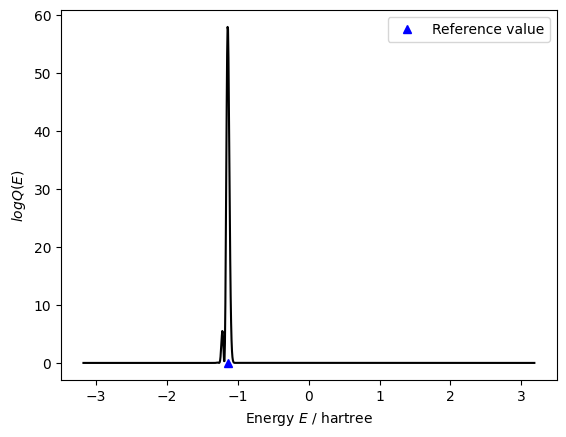

In [9]:
import matplotlib.pyplot as plt

posterior = bayesian_update(phi, prior, k_list, beta_list, logical_results)
x_energy = -phi / chem_data.DELTAT
plt.plot(x_energy, posterior, "k-")
plt.plot(chem_data.APPROX_ENERGY, 0, "b^", label="Reference value")
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"$log Q(E)$")
plt.legend()